In [3]:
# import custom library
from ipynb.fs.full.utility import *
from ipynb.fs.full.dataset import *

In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset, DataLoader

In [5]:
torch.__version__

'1.12.1'

In [6]:
# hyper params
nb_inputs  = 123
nb_hidden = 100
nb_outputs = 25

time_step = 1e-3
nb_steps  = 100

BATCH_SIZE = 512

seed = 0

In [7]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [8]:
allCQT, allLabel = get_dataset(npzs_8th)

In [9]:
allCQT.shape

(474588, 123)

In [10]:
allLabel.shape

(474588,)

In [11]:
x_train, x_val, x_test, y_train, y_val, y_test = partitionDataset(allCQT, allLabel)

In [12]:
x_train.shape

(379670, 123)

In [13]:
x_val.shape

(47459, 123)

In [14]:
x_test.shape

(47459, 123)

In [15]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T
 

def sparse_data_generator(X, y, x_v, y_v, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))
    
    labels_v = np.array(y_v,dtype=int)
    batch_size_v = len(x_v)//number_of_batches
    sample_index_v = np.arange(len(x_v))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=int)
    unit_numbers = np.arange(nb_units)
    
    firing_times_v = np.array(current2firing_time(x_v, tau=tau_eff, tmax=nb_steps), dtype=int)
    
    
    if shuffle:
        np.random.shuffle(sample_index)
        np.random.shuffle(sample_index_v)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        batch_index_v = sample_index_v[batch_size_v*counter:batch_size_v*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
        
        coo_v = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index_v):
            c = firing_times_v[idx]<nb_steps
            times, units = firing_times_v[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo_v[0].extend(batch)
            coo_v[1].extend(times)
            coo_v[2].extend(units)

        i_v = torch.LongTensor(coo_v).to(device)
        v_v = torch.FloatTensor(np.ones(len(coo_v[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)
        x_v_batch = torch.sparse.FloatTensor(i_v, v_v, torch.Size([batch_size_v,nb_steps,nb_units])).to(device)
        y_v_batch = torch.tensor(labels_v[batch_index_v],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device), x_v_batch.to(device=device), y_v_batch

        counter += 1

In [16]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [17]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [18]:
# run this if loading previous weight
#modelWeight = torch.load('/userhome/cs2/u3556571/4th_majorminor/result_3layer/5_epoch.pt')
#w1 = modelWeight['w1']
#w2 = modelWeight['w2']

In [19]:
w1.shape

torch.Size([123, 100])

In [20]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [21]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [22]:
def run_snn(inputs, batch_size):

    # Hidden layer 
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn1 = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem1 = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem_rec1 = []
    spk_rec1 = []
    for t in range(nb_steps):
        mthr = mem1-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn1 +h1[:,t]
        new_mem = (beta*mem1 +syn1)*(1.0-rst)

        mem_rec1.append(mem1)
        spk_rec1.append(out)
        
        mem1 = new_mem
        syn1 = new_syn

    # Stack is from list to tensor, with desired dim
    mem_rec1 = torch.stack(mem_rec1,dim=1)
    spk_rec1 = torch.stack(spk_rec1,dim=1)

    # Output layer
    h2= torch.einsum("abc,cd->abd", (spk_rec1, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec1, spk_rec1]
    return out_rec, other_recs

In [26]:
def train(x_train, y_train, x_val, y_val, lr=2e-3, batch_size=512, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    accs_hist = []
    lossv_hist = []
    accsv_hist = []
    for e in range(nb_epochs):
        local_loss = []
        local_accs = []
        local_lossv = []
        local_accsv = []
        for x_local, y_local, x_val_local, y_val_local in sparse_data_generator(x_train, y_train, x_val, y_val, batch_size, nb_steps, nb_inputs):
            
            # training
            output,_ = run_snn(x_local.to_dense(), batch_size)
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)
            _,am=torch.max(m,1)      # argmax over output units
            tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
            local_accs.append(tmp)
            
            # validation
            output_v,_ = run_snn(x_val_local.to_dense(), x_val_local.shape[0])
            m_v,_=torch.max(output_v,1)
            log_p_y_v = log_softmax_fn(m_v)
            loss_val_v = loss_fn(log_p_y_v, y_val_local)
            _,am_v=torch.max(m_v,1)      # argmax over output units
            tmp_v = np.mean((y_val_local==am_v).detach().cpu().numpy()) # compare to labels
            
            local_lossv.append(loss_val_v.item())
            local_accsv.append(tmp_v)
        
        accumEpoch = 0
        
        # calculate the loss
        mean_loss = np.mean(local_loss)
        mean_accs = np.mean(local_accs)
        mean_lossv = np.mean(local_lossv)
        mean_accsv = np.mean(local_accsv)
        print("Epoch %i: loss=%.5f accs=%.5f val_loss=%.5f val_accs=%.5f"%(accumEpoch+e+1,mean_loss, mean_accs, mean_lossv, mean_accsv))
        
        # add to loss history
        loss_hist.append(mean_loss)
        accs_hist.append(mean_accs)
        lossv_hist.append(mean_lossv)
        accsv_hist.append(mean_accsv)
        
        
        savePath = '/userhome/cs2/u3556571/8th/3layer/' + str(accumEpoch+e+1) + '_epoch.pt'
        torch.save({
            'w1':w1,
            'w2':w2
        }, savePath)
    return loss_hist, accs_hist, lossv_hist, accsv_hist

In [ ]:
loss_hist, accs_hist, lossv_hist, accsv_hist = train(x_train, y_train, x_val, y_val, lr=2e-3, nb_epochs=100)

Epoch 1: loss=2.84285 accs=0.13398 val_loss=2.84237 val_accs=0.13223
Epoch 2: loss=2.80890 accs=0.14015 val_loss=2.80838 val_accs=0.14037
Epoch 3: loss=2.80379 accs=0.14191 val_loss=2.80302 val_accs=0.14020
Epoch 4: loss=2.80107 accs=0.14249 val_loss=2.80056 val_accs=0.14183
Epoch 5: loss=2.79901 accs=0.14287 val_loss=2.79939 val_accs=0.14136
Epoch 6: loss=2.79224 accs=0.14312 val_loss=2.79319 val_accs=0.14039
Epoch 7: loss=2.78888 accs=0.14369 val_loss=2.79017 val_accs=0.14227
Epoch 8: loss=2.78732 accs=0.14322 val_loss=2.78960 val_accs=0.14259
Epoch 9: loss=2.78612 accs=0.14367 val_loss=2.78841 val_accs=0.14216
Epoch 10: loss=2.78540 accs=0.14374 val_loss=2.78836 val_accs=0.14370
Epoch 11: loss=2.78443 accs=0.14398 val_loss=2.78662 val_accs=0.14364
Epoch 12: loss=2.78553 accs=0.14306 val_loss=2.78943 val_accs=0.14170
Epoch 13: loss=2.78433 accs=0.14357 val_loss=2.78861 val_accs=0.14174
Epoch 14: loss=2.78260 accs=0.14375 val_loss=2.78663 val_accs=0.14147
Epoch 15: loss=2.78264 accs=0

In [24]:
loss_hist, accs_hist, lossv_hist, accsv_hist = train(x_train, y_train, x_val, y_val, lr=1e-3, nb_epochs=100)

Epoch 1: loss=2.82994 accs=0.15184 val_loss=2.82907 val_accs=0.15106
Epoch 2: loss=2.76724 accs=0.16898 val_loss=2.76490 val_accs=0.16705
Epoch 3: loss=2.75401 accs=0.17186 val_loss=2.75445 val_accs=0.16909
Epoch 4: loss=2.74022 accs=0.17614 val_loss=2.74406 val_accs=0.17223
Epoch 5: loss=2.72688 accs=0.18029 val_loss=2.73391 val_accs=0.17736
Epoch 6: loss=2.71415 accs=0.18414 val_loss=2.72618 val_accs=0.17668
Epoch 7: loss=2.70184 accs=0.18679 val_loss=2.71817 val_accs=0.17926
Epoch 8: loss=2.69344 accs=0.18907 val_loss=2.71308 val_accs=0.18035
Epoch 9: loss=2.68613 accs=0.19166 val_loss=2.70751 val_accs=0.18210
Epoch 10: loss=2.67771 accs=0.19252 val_loss=2.69981 val_accs=0.18400
Epoch 11: loss=2.67301 accs=0.19311 val_loss=2.69704 val_accs=0.18484
Epoch 12: loss=2.66828 accs=0.19533 val_loss=2.69564 val_accs=0.18362
Epoch 13: loss=2.66479 accs=0.19494 val_loss=2.69372 val_accs=0.18472
Epoch 14: loss=2.66044 accs=0.19575 val_loss=2.69039 val_accs=0.18438
Epoch 15: loss=2.65780 accs=0

KeyboardInterrupt: 

In [3]:
loss = []
accs = []
val_loss = []
val_accs = []
sentence = string.split('\n')
for sentenc in sentence:
    temp = sentenc.split(' ')
    loss.append(float(temp[2].split('=')[1]))
    accs.append(float(temp[3].split('=')[1]))
    val_loss.append(float(temp[4].split('=')[1]))
    val_accs.append(float(temp[5].split('=')[1]))

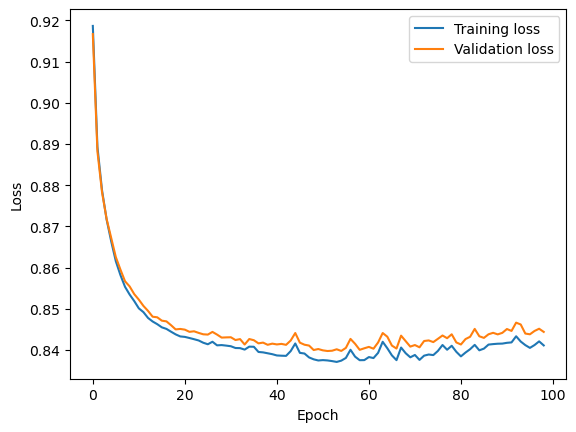

In [5]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

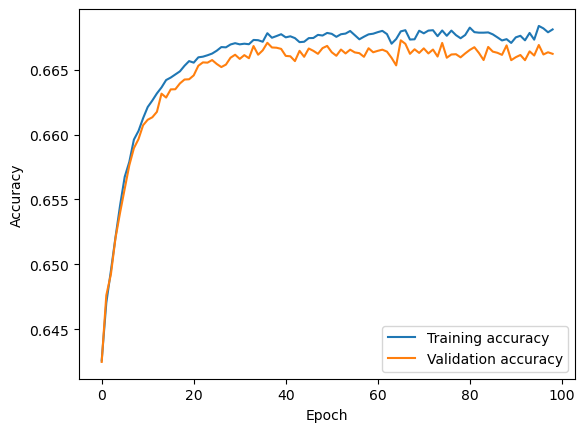

In [6]:
plt.plot(accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

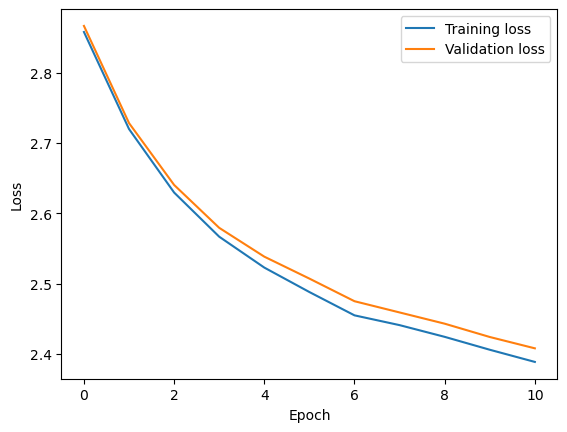

In [7]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

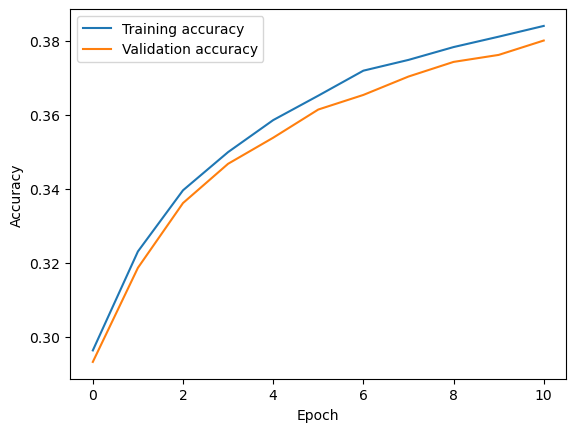

In [11]:
plt.plot(accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [40]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.389
Test accuracy: 0.385


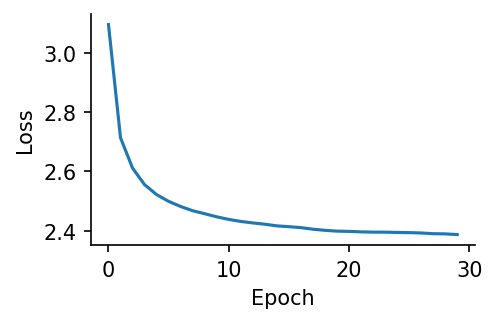

In [43]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [25]:
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local,_,__ in sparse_data_generator(x_data, y_data, x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense(), batch_size)
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [26]:
#test
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.451
Test accuracy: 0.446


In [29]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.451
Test accuracy: 0.446
